In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [2]:
# Carregando o dataset
df_salarios = pd.read_csv('data/salarios.csv', delimiter=',')

# Características das variáveis do dataset
df_salarios.info()

# Estatísticas univariadas
df_salarios.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nome          15 non-null     object 
 1   salario       15 non-null     float64
 2   rh1           15 non-null     float64
 3   econometria1  15 non-null     float64
 4   rh2           15 non-null     float64
 5   econometria2  15 non-null     float64
dtypes: float64(5), object(1)
memory usage: 852.0+ bytes


,salario,rh1,econometria1,rh2,econometria2
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2032.150578,7.180000,6.400000,6.400000,3.240000
std,312.507361,3.169317,2.221647,2.221647,1.061367
min,1505.627563,1.400000,3.000000,3.000000,1.500000
25%,1870.515320,4.450000,4.500000,4.500000,2.250000
50%,2001.654297,8.000000,7.000000,7.000000,3.500000
75%,2219.607788,9.950000,8.000000,8.000000,4.000000
max,2525.340820,10.000000,9.500000,9.500000,4.750000


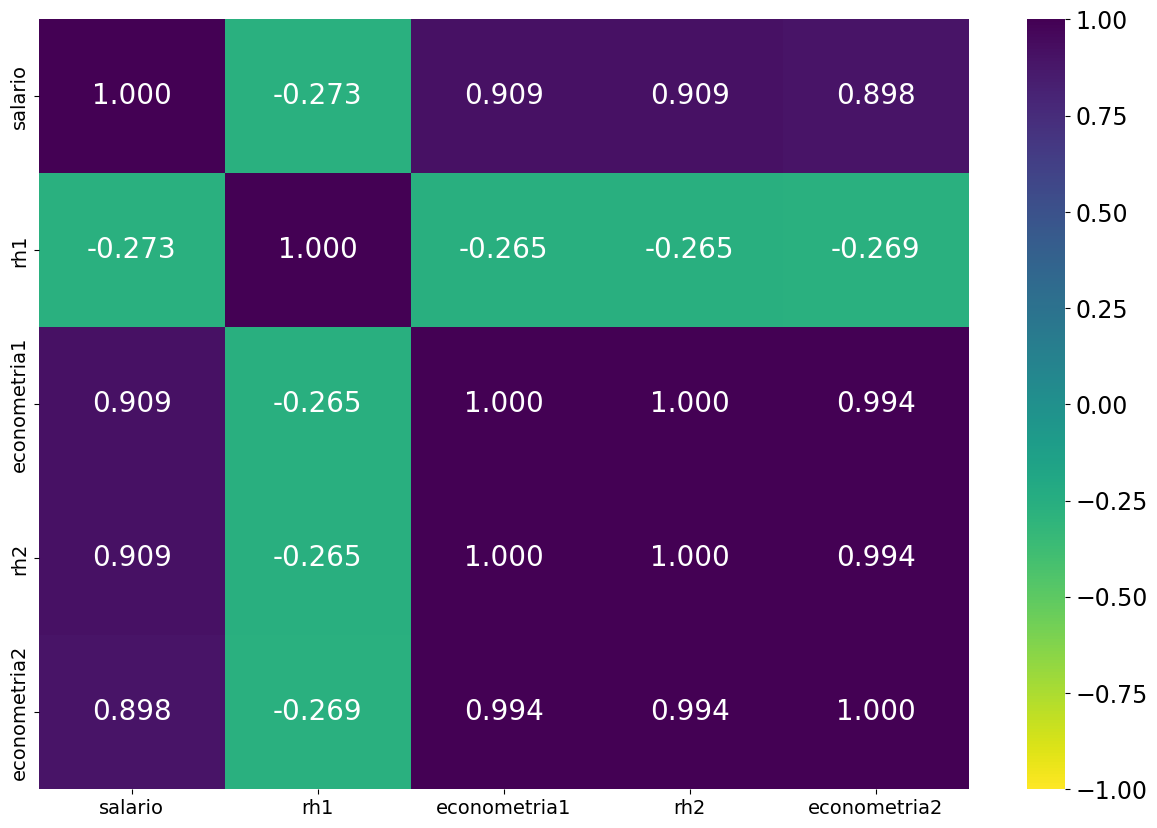

In [3]:
# Matriz de correlações
correlation_matrix = df_salarios.iloc[:,1:6].corr()
correlation_matrix

# Mapa de calor com as correlações entre todas as variáveis quantitativas
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".3f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 20}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=14)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

Correlação: -0.2651
 P-value: 0.3397 



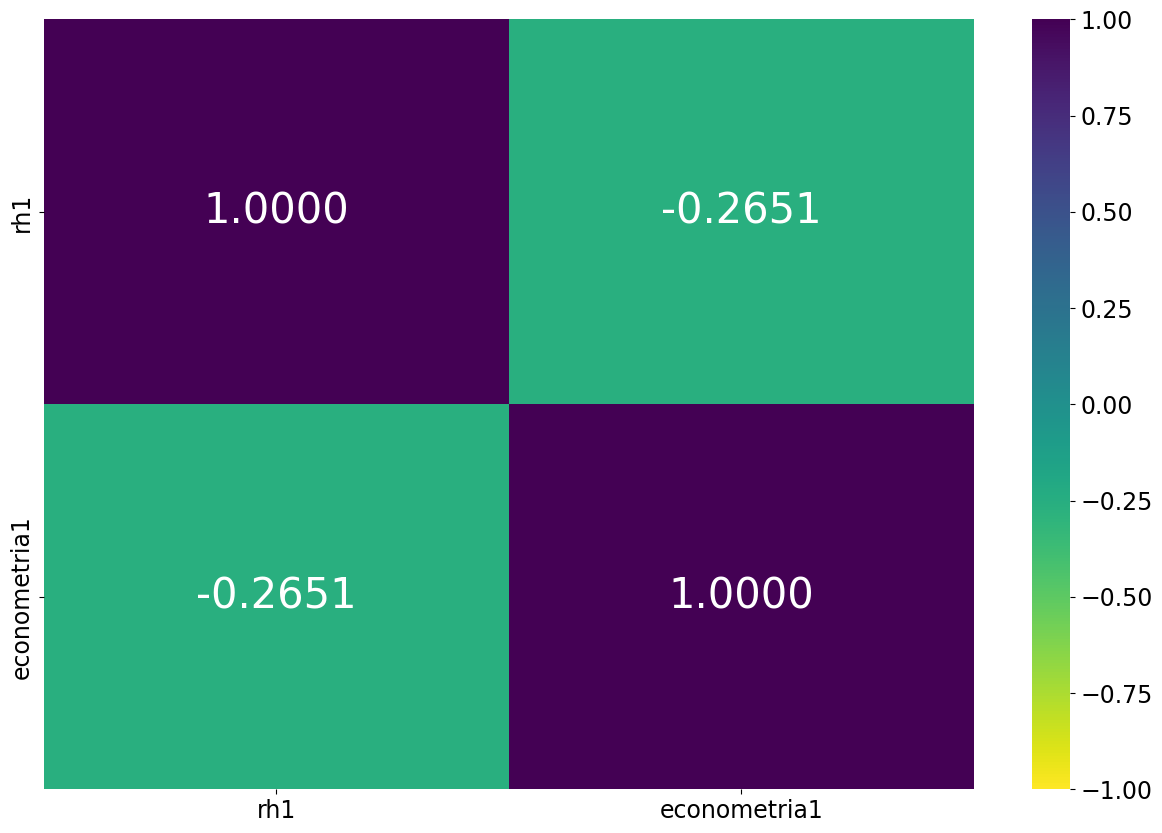

In [14]:
# CORRELAÇÃO BAIXA (variáveis 'rh1' e 'econometria1'):

# Correlação entre 'rh1' e 'econometria1', com p-value
corr1, p_value1 = pearsonr(df_salarios['rh1'], df_salarios['econometria1'])
print("Correlação: {:.4f}\n".format(corr1), "P-value: {:.4f}".format(p_value1), '\n')

# Matriz de correlação (maneira simples) pela função 'corr'
corr1 = df_salarios[['rh1','econometria1']].corr()
corr1

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

corr1b = pg.rcorr(df_salarios[['rh1','econometria1']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr1b

# Mapa de calor com a correlação entre 'rh1' e 'econometria1'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr1, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

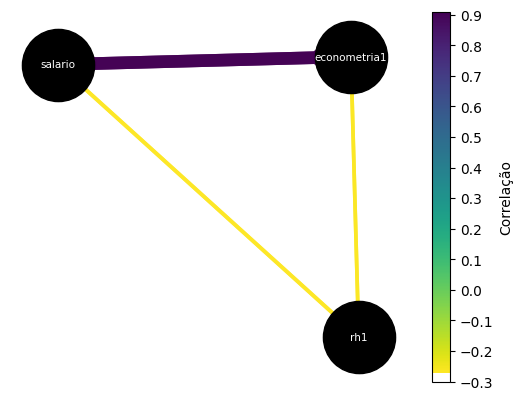

In [5]:
# Grafo com a inter-relação entre as variáveis do dataframe 'df1'

df1 = df_salarios[['salario','rh1','econometria1']]
cormat1 = df1.corr()
cormat1

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat1.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat1.columns):
    for j, variable2 in enumerate(cormat1.columns):
        if i != j:
            correlation = cormat1.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),1),
                         max(correlations), 0.1))

# Exibição do gráfico
plt.show()

In [6]:
# Modelo 1
modelo1 = sm.OLS.from_formula('salario ~ rh1 + econometria1', df_salarios).fit()

print(modelo1.summary())

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     28.77
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.64e-05
Time:                        19:13:04   Log-Likelihood:                -93.759
No. Observations:                  15   AIC:                             193.5
Df Residuals:                      12   BIC:                             195.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1246.6172    163.783      7.611   

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [16]:
# Procedimento stepwise modelo1
from statstests.process import stepwise

modelo1_step = stepwise(modelo1, pvalue_limit=0.05)
print(modelo1_step)

Regression type: OLS 

Estimating model...: 
 salario ~ Q('rh1') + Q('econometria1')

 Discarding atribute "Q('rh1')" with p-value equal to 0.7851743044424093 

Estimating model...: 
 salario ~ Q('econometria1')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('rh1')", 'p-value': np.float64(0.7851743044424093)}

 Model after stepwise process...: 
 salario ~ Q('econometria1') 

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     61.85
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.69e-06
Time:                        19:45:27   Log-Likelihood:                -93.807
No. Observations:                  15   AIC:                             191.6
Df Resi

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [7]:
# Diagnóstico de multicolinearidade (Variance Inflation Factor
# e Tolerance)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculando os valores de VIF
X1 = sm.add_constant(df_salarios[['rh1', 'econometria1']])
VIF = pd.DataFrame()
VIF["Variável"] = X1.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X1.values, i+1)
              for i in range(X1.shape[1]-1)]

# Calculando as Tolerâncias
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF

,Variável,VIF,Tolerância
0,rh1,1.075576,0.929735
1,econometria1,1.075576,0.929735


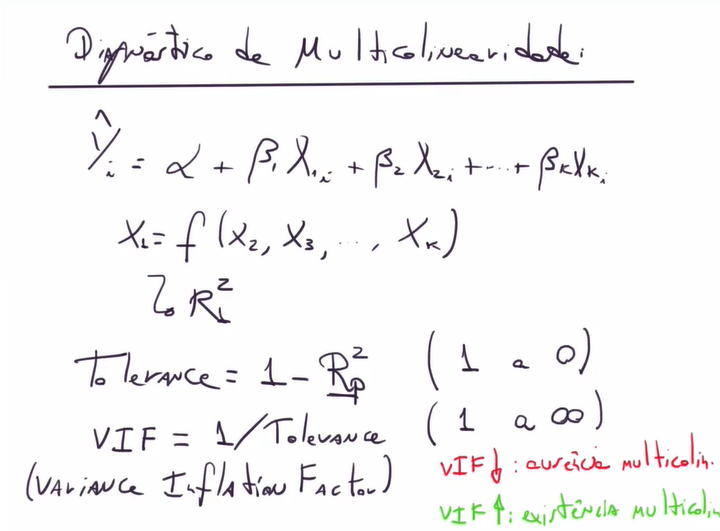

Correlação: 0.9939 P-value: 0.0000 



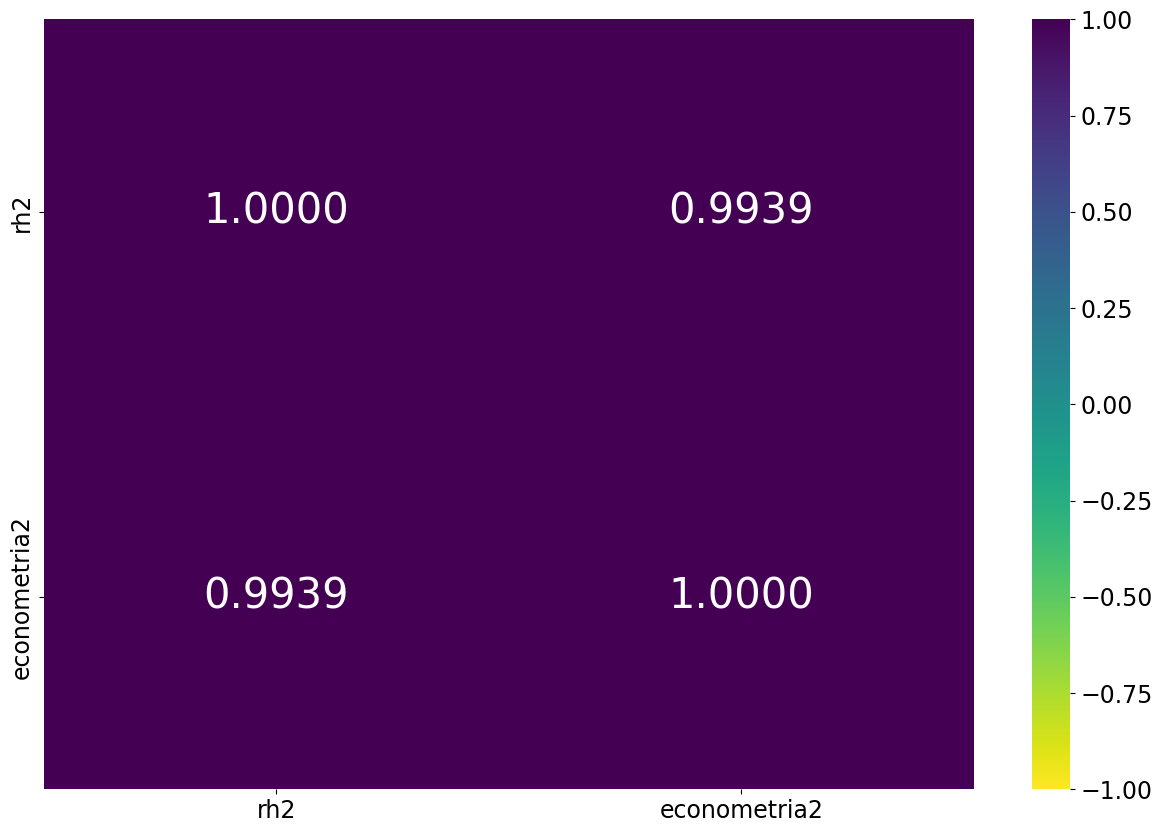

In [21]:
# CORRELAÇÃO MUITO ALTA (variáveis 'rh2' e 'econometria2'):

# Correlação entre 'rh2' e 'econometria2', com p-value
corr2, p_value2 = pearsonr(df_salarios['rh2'], df_salarios['econometria2'])
print("Correlação: {:.4f}".format(corr2), "P-value: {:.4f}".format(p_value2), '\n')

# Matriz de correlação (maneira simples) pela função 'corr'
corr2 = df_salarios[['rh2','econometria2']].corr()
corr2

# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'
import pingouin as pg

corr2b = pg.rcorr(df_salarios[['rh2','econometria2']], method='pearson',
                  upper='pval', decimals=6,
                  pval_stars={0.01: '***',
                              0.05: '**',
                              0.10: '*'})
corr2b

# Mapa de calor com a correlação entre 'rh2' e 'econometria2'
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(corr2, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 30}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=17)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=17)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

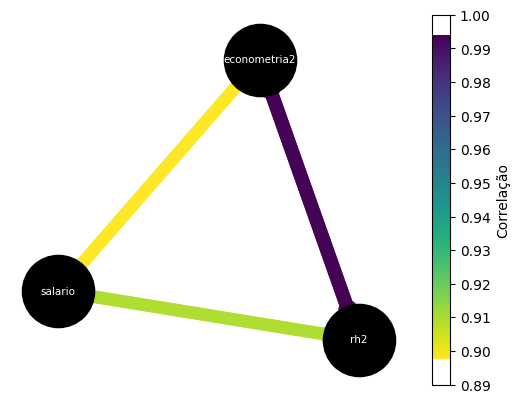

In [18]:
# Grafo com a inter-relação entre as variáveis do dataframe 'df2'

df2 = df_salarios[['salario','rh2','econometria2']]
cormat2 = df2.corr()
cormat2

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in cormat2.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(cormat2.columns):
    for j, variable2 in enumerate(cormat2.columns):
        if i != j:
            correlation = cormat2.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('viridis_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.9)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations) - 0.01,2),
                         max(correlations) + 0.01, 0.01))

# Exibição do gráfico
plt.show()

In [19]:
# Modelo 2
modelo2 = sm.OLS.from_formula('salario ~ rh2 + econometria2', df_salarios).fit()

print(modelo2.summary())

# In[6.9]: Diagnóstico de multicolinearidade (Variance Inflation Factor
#e Tolerance)

# Calculando os valores de VIF
X2 = sm.add_constant(df_salarios[['rh2', 'econometria2']])
VIF = pd.DataFrame()
VIF["Variável"] = X2.columns[1:]
VIF["VIF"] = [variance_inflation_factor(X2.values, i+1)
              for i in range(X2.shape[1]-1)]

# Calculando as Tolerâncias
VIF["Tolerância"] = 1 / VIF["VIF"]
VIF

                            OLS Regression Results                            
Dep. Variable:                salario   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     29.10
Date:                Tue, 13 Aug 2024   Prob (F-statistic):           2.50e-05
Time:                        20:01:07   Log-Likelihood:                -93.688
No. Observations:                  15   AIC:                             193.4
Df Residuals:                      12   BIC:                             195.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1241.8527    130.172      9.540   

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


,Variável,VIF,Tolerância
0,rh2,82.061458,0.012186
1,econometria2,82.061458,0.012186
